In [1]:
# Project Scope

# Goals: Predict the height of the waves
# Dataset: Global Ocean Waves Analysis and Forecast (https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_WAV_001_027/download?dataset=cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_202411)
# Analysis: Predict Sea surface wave maximum height (VCMX)

# Results: 0.9981659439482071


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xarray as xr
import netCDF4
from netCDF4 import Dataset
from scipy.io import netcdf

In [2]:
#Reading the file
file = "/Users/jcastropicco/Desktop/cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_1735257954132.nc"
dataset = Dataset(file, mode="r")
#print(dataset.variables.keys())

import numpy as np

features = [
    'latitude', 'longitude', 'VHM0', 'VCMX', 'VHM0_SW1', 'VHM0_SW2',
    'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED',
    'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK'
]


# Creating a baseline DataFrame with latitude and longitude
latitude = dataset.variables["latitude"][:]
longitude = dataset.variables["longitude"][:]
lon, lat = np.meshgrid(longitude, latitude)


# Instantiate the DataFrame with the coordinates
df = pd.DataFrame({
    "latitude": lat.flatten(),
    "longitude": lon.flatten()
})

# Function for cleaning and adding every feature
def agregar_feature(df, feature, dataset, missing_value=-32767):
    try:
        # Extract data from the variable
        data = dataset.variables[feature][:]
        
        # Handling missing values
        data_cleaned = np.where(data == missing_value, np.nan, data)

        # Alligning dimensions
        if data_cleaned.ndim == 3:  # (time, latitude, longitude)
            data_flat = data_cleaned[0, :, :].flatten()
        elif data_cleaned.ndim == 2:  # (latitude, longitude)
            data_flat = data_cleaned.flatten()
        elif data_cleaned.ndim == 1:  # 1D (time, etc.)
            data_flat = np.tile(data_cleaned, len(lat.flatten()) // len(data_cleaned))
        else:
            print(f"Warning: '{feature}' has unsupported dimensions.")
            return df

        # Adding the column to the DataFrame
        df[feature] = data_flat

    except KeyError:
        print(f"Error: The variable '{feature}' isn't in the file.")
    except Exception as e:
        print(f"Error while processing '{feature}': {e}")

    return df

# Adding every feature to the DataFrame
for feature in features:
    if feature not in ["latitude", "longitude"]:  # Already added.
        df = agregar_feature(df, feature, dataset)

# Cleaning row with Nan values
df_cleaned = df.dropna()

# Check the final result
print(df_cleaned.head())



         latitude   longitude  VHM0  VCMX  VHM0_SW1  VHM0_SW2  VHM0_WW  \
459953 -71.166664  -10.583333  0.24  0.41      0.05      0.02     0.23   
459954 -71.166664  -10.500000  0.24  0.41      0.06      0.01     0.23   
459955 -71.166664  -10.416667  0.24  0.41      0.06      0.01     0.23   
462113 -71.166664  169.416672  0.32  0.55      0.06      0.05     0.31   
462114 -71.166664  169.500000  0.32  0.54      0.05      0.04     0.31   

              VMDR    VMDR_SW1   VMDR_SW2  ...  VMXL       VPED  VSDX  VSDY  \
459953   44.660004    9.090004  89.599998  ...  0.33  50.180004 -0.03 -0.02   
459954   44.160004  358.489990  99.990005  ...  0.33  52.500004 -0.03 -0.02   
459955   44.160004  358.489990  99.990005  ...  0.32  52.500004 -0.03 -0.02   
462113  106.290001  167.639999  56.110004  ...  0.24  82.500000 -0.05  0.02   
462114  106.209999  177.679993  47.340004  ...  0.24  82.500000 -0.05  0.02   

        VTM01_SW1  VTM01_SW2  VTM01_WW  VTM02  VTM10  VTPK  
459953       2.06  

In [3]:
# Separating features and target

y = df_cleaned.VCMX
X = df_cleaned.drop(columns="VCMX")

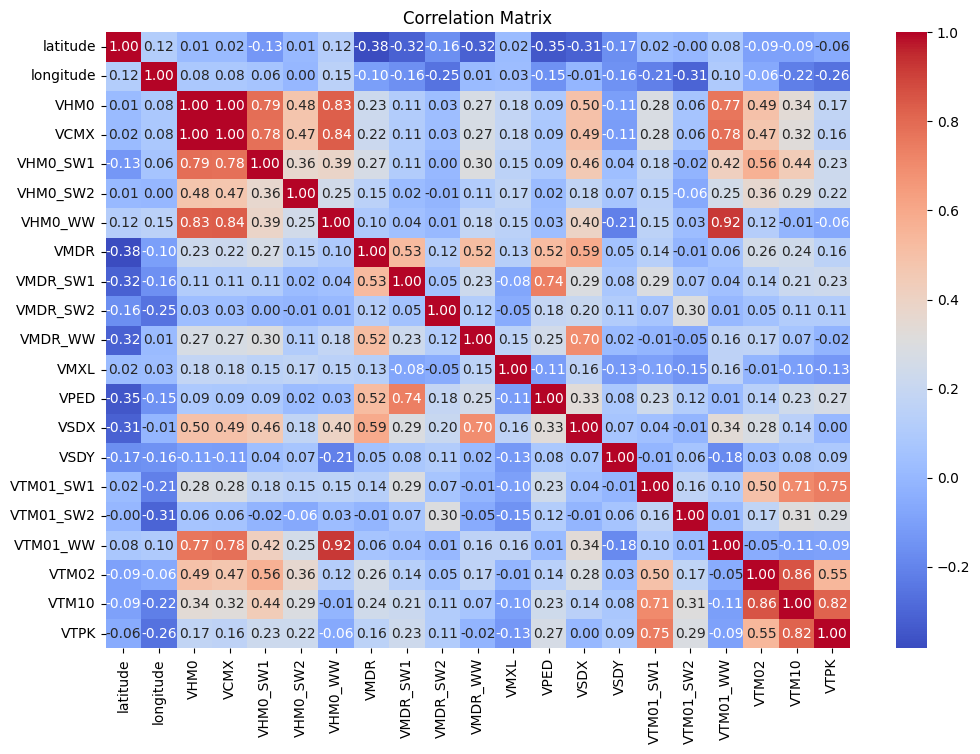

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = df_cleaned.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scaling variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA dimensionality reduction
pca = PCA(n_components=13)  # Elegir el número de componentes principales
X_pca = pca.fit_transform(X_scaled)

In [5]:
# Train-test data split 
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Training the first model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Prediction
y_pred = lr.predict(x_test)

# Testing the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 0.10104575753211975
MAE: 0.23812545835971832


In [7]:
print(lr.score(x_test, y_test))

0.9790289998054504


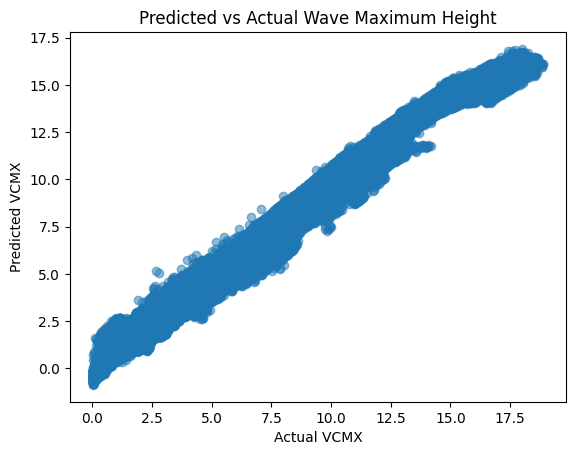

In [8]:
from matplotlib import pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual VCMX")
plt.ylabel("Predicted VCMX")
plt.title("Predicted vs Actual Wave Maximum Height")
plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'n_estimators': [50, 100],  # Reduce las opciones para número de árboles
    'max_depth': [10, 20],     # Prueba menos valores de profundidad
    'min_samples_split': [2, 5],  # Reduce las combinaciones posibles
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt'],  # Menos opciones
    'bootstrap': [True]  # Elimina opciones innecesarias
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  cv=3,
                  scoring=make_scorer(mean_squared_error, greater_is_better=False),
                  n_jobs=-1,
                  verbose=2)

grid_search.fit(x_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor puntuación (MSE negativo): {grid_search.best_score_}")

best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=11.9min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=23.4min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=13.6min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
31 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=11.9min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=23.5min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=28.5min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=20.6min
[CV] END bootstrap=True, max_depth=20, max_feature

In [13]:
y_pred_rf = best_rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred_rf)
print(f"MSE en conjunto de prueba: {mse}")

mae = mean_absolute_error(y_test, y_pred_rf)
print(f"MAE en conjunto de prueba: {mae}")


MSE en conjunto de prueba: 0.008837135171717145
MAE en conjunto de prueba: 0.06119602166712576


In [11]:
# Notes

#Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
#Mejor puntuación (MSE negativo): -0.009179081172873072

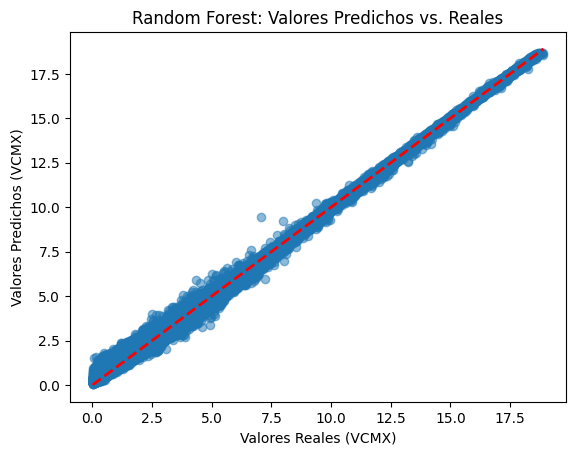

In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales (VCMX)")
plt.ylabel("Valores Predichos (VCMX)")
plt.title("Random Forest: Valores Predichos vs. Reales")
plt.show()



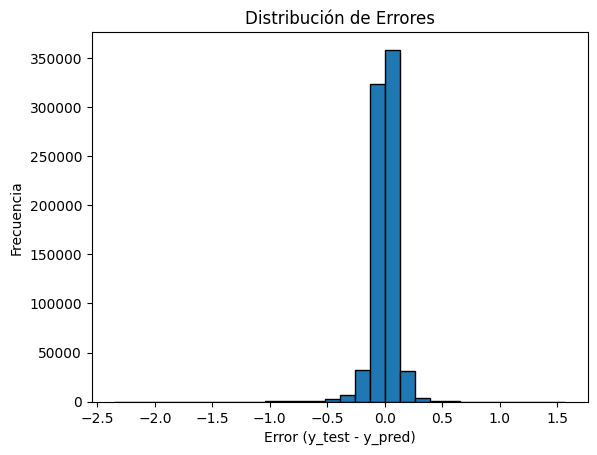

In [15]:
errors = y_test - y_pred_rf
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Error (y_test - y_pred)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores")
plt.show()


In [17]:
print(grid_search.score(x_test, y_test))

print(best_rf.score(x_test, y_test))

-0.008837135171717145
0.9981659439482071
